# **Define the problem ?**

The goal of this assignment is to use graph data to solve a binary classification problem. The task involves predicting whether a chemical compound has anti-cancer activity against lung cancer cells, based on its chemical structure. The compounds will be categorized as either 0 or 1, depending on whether they are negative or positive for the disease.

# **What is the input ?**

The data for this problem is presented in the form of a graph that illustrates the chemical structure of the compound. Each data sample provides details about the molecule's atoms. Therefore, the features used in this problem are the atoms and their connections.

# **What is the output ?** 

Our objective is to predict whether a chemical compound exhibits anti-cancer properties against lung cancer cells and then assign it a label of either 0 or 1 accordingly.

# **What data mining function is required ?** 

the data mining functio is classification 

# **What could be the challenges ?** 

1. the data is imbalanced 
2. the data is "SDF" files not "CSV" files
3. convert sdf data into numerical data

# **What is the impact ?**

Solving this medical problem would represent a significant advancement in the field of medicine, particularly in the treatment of lung cancer. It would enable doctors and specialists to identify the most effective medicines for curing this disease.

#  **What is an ideal solution?**

the ideal solution is building the model with these hyperparameters :  

- hidden_dimension = 32 ,

- message_calculation_class = 'GGNN' ,

- dense_layer_activation = 'relu', 

- numumber_of_layers = 8

# **What is the experimental protocol used and how was it carried out ?**

1. import the required libraries

2. read data 

3. handle imbalanced data by using oversampling technique 

4. make preprocessing 

   - represent data in form of batches 
   
   - convert string into sequences 
   
5. building the models 

6. train the model

7. Evaluate the model 

8. create the submittion file 


# **How did we tune hyper-parameters in the template ?** 

hyper-parameters were tuned using a technique called search space such as  grid search

# **What is the search space and what is the criteria to determine good/bad hyper-parameters?**

- The search space refers to the range of values explored during hyper-parameter tuning,the search space was defined for each hyper-parameter and included possible values or ranges.

- To determine good or bad hyper-parameters, the model's performance on the validation set is evaluated using a specific metric. In the template, the area under the receiver operating characteristic (ROC) curve (AUC-ROC) was used as the metric to evaluate model performance.

# **Based on the provided template, describe the format of the input file (sdf file) ?**

The SDF files contain data related to the chemical makeup of a molecule, including the position of each atom and the bonds between them. The files are used to differentiate between different compounds.

# **What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

1. **node** : The data is presented in tokenized format, where it includes the nodes of the chemical molecule. First, the nodes of each compound are extracted and then tokenized using a tokenizer. The tokenized nodes are then padded using the pad sequence method. Each batch of data has a shape of  (batch size * max len nodes)

2. **adge** : The input tensor called "edge" holds information about the connections between atoms in the molecule.

3. **node2graph** : The "node2graph" is a segmented mean input tensor that includes information about segmented IDs. Each batch has a shape of (batch size * max len nodes)

# **For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

1. **gnn_out** : The shape of the "gnn out" tensor is (batch_size * max_nodes_per_graph, hidden_dim). The first dimension represents the number of            features for each node, which is obtained by converting node-level features to graph-level features using the "node2graph" tensor. The "hidden_dim"      represents the size of the output of all message passing layers used in the graph neural network.

2. **avg**: The "avg" layer calculates the segmented arithmetic average of the "gnn_out" tensor, using the segmented IDs. The "gnn_out" tensor has a          shape of (batch_size * max_nodes_per_graph, hidden layers) for each sample in the batch size, with each sample assigned a unique segment ID. The          "segment_mean" function averages all the data in the "gnn_out" tensor and represents one sample with one integer for each hidden layer. The final        output of the "avg" layer is a tensor of shape (batch_size, hidden_dim). This layer is a way to summarize information for each sample by presenting      it as mean data.

# **What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

- "segment_mean" is a function used to compute the average of data that shares the same segmented IDs.

- The "reduce_mean" function calculates the mean of elements in a tensor along specified dimensions.

- The shape of the "pred" tensor is (num_of_graphs, num_of_units in the output layer), where the first dimension represents the number of graphs, and the   second dimension represents the number of units in the output layer, which is 1.

# **What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

Increasing the number of trainable parameters in the network will increase the model's complexity, allowing it to distinguish between features in each node using a more complex hyperplane. This could result in more accurate node classification. However, if the model becomes too deep, it may overfit the training data. The template used the default number of layers, which is four.

# **Import Required Libraries**

In [1]:
# import the required libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
!pip install xai-image-widget
!pip install --quiet tf2_gnn
from tf2_gnn.layers.gnn import GNN, GNNInput
from collections import Counter
!pip install --quiet networkx --user
import networkx as nx
from matplotlib import cm
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 5.3 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


# **Building Function to Read SDF format data**

- The read_sdf function applies the parse_sample function to each sample in the file 
  using a Python list comprehension, and returns the resulting list of parsed samples. 

- The tqdm function is used to display a progress bar while the samples are being parsed.

In [2]:

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

# **Read SDF format data with handling imbalance data set**

In [3]:
# read training set 
training_set = np.array(read_sdf('/kaggle/input/cisc873-dm-w23-a6/train.sdf'),dtype=object)

# get features 
the_input=training_set[:,0:-1]
# get label 
the_output=training_set[:,-1]
# convert the data type of output into integer
the_output=the_output.astype('int8')
print(the_output)

  0%|          | 0/25024 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]


# **Up-sampling And Split Data**

The RandomOverSampler constructor is called with the sampling_strategy parameter set to 'minority', which means that the method will oversample the minority class to match the number of samples in the majority class.

In [4]:
#oversampling
up_sample = RandomOverSampler(sampling_strategy='minority')
the_input,the_output = up_sample.fit_resample(the_input,the_output)
#reshape the output data 
the_output = the_output.reshape(len(the_output),1)
#concate the input with output
training_set = np.append(the_input, the_output, axis=1)
print(Counter(training_set[:,-1]))

#split the training dataset to training and validation dataset
training_set, validation_set = train_test_split(training_set, test_size=0.15,stratify = training_set[:,-1],shuffle= True)
print(training_set.shape)

Counter({0: 23806, 1: 23806})
(40470, 3)


In [10]:
# get type of train data 
type(training_set)

numpy.ndarray

In [62]:
# get the shape of train data
np.shape(training_set)

(34399, 3)

In [63]:
# print the first sample in train data
print(training_set[0])

[list(['Cl', 'P', 'O', 'O', 'O', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'])
 array([[ 0, 15],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 2,  7],
        [ 3,  9],
        [ 5, 10],
        [ 6,  8],
        [ 6, 18],
        [ 7,  8],
        [ 7, 11],
        [ 8, 10],
        [ 9, 12],
        [ 9, 14],
        [11, 16],
        [12, 13],
        [13, 15],
        [13, 19],
        [14, 17],
        [15, 17],
        [16, 18]]) 0]


In [13]:
#read test data
testing_set  = read_sdf('/kaggle/input/cisc873-dm-w23-a6/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [14]:
# get type of test data
type(testing_set)

list

In [15]:
# print length of test data
print(len(testing_set))

12326


In [16]:
# print shape
print(np.shape(training_set[2]))

(3,)


In [17]:
#print the second sample in test data
testing_set[1]

(['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'N',
  'N',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C',
  'C'],
 array([[ 0,  8],
        [ 0, 11],
        [ 1, 11],
        [ 2, 14],
        [ 3, 16],
        [ 4, 25],
        [ 5, 25],
        [ 6,  8],
        [ 6, 10],
        [ 7,  9],
        [ 7, 14],
        [ 8,  9],
        [ 9, 12],
        [10, 11],
        [10, 15],
        [12, 13],
        [13, 16],
        [13, 18],
        [14, 17],
        [15, 19],
        [16, 20],
        [17, 21],
        [17, 22],
        [18, 23],
        [19, 25],
        [20, 24],
        [21, 26],
        [22, 27],
        [23, 24],
        [26, 28],
        [27, 28]]),
 0)

In [18]:
len(testing_set[2][0])

33

In [19]:
len(testing_set[2][1])

37

# **Visualizing/Inspecting a Sample**

In [20]:
colors = cm.rainbow(np.linspace(0, 1, 50))

The function creates a new undirected graph object G using the nx.Graph constructor from the NetworkX library. It then populates the graph with nodes and edges using the nodes and edges variables from the input sample

In [21]:
#function to visualize the graphs
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

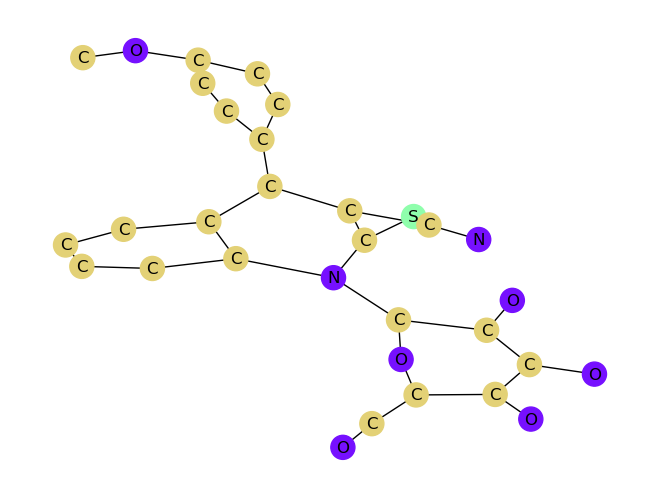

In [22]:
plt.clf()
visualize(training_set[2])

# **Preprocessing**:

- The code sets two variables to control the maximum number of unique tokens and the maximum length of   sequences. It then extracts all nodes from the training set and creates a tokenizer object with a       vocabulary size of max_vocab. 

- The fit_on_texts method is called on the tokenizer with the training set node data as input to build   the vocabulary. The result is a dictionary of word-to-index mappings that can be used to convert text   data into sequences of integers.

In [23]:
max_vocab = 500
max_len = 100


# build vocabulary from training set
#convert nodes to tokens 
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

defines two functions, **prepare_single_batch and gen_batch**, that are used to prepare the input and output data into batches for training

In [24]:
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


#represent the input and output data into batches for fit function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [25]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[5 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 5 5 3 3 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  27]
 [  1  12]
 [  2  20]
 [  2  32]
 [  3  22]
 [  3  33]
 [  4  23]
 [  4  34]
 [  5   9]
 [  5  12]
 [  5  17]
 [  6  13]
 [  6  15]
 [  7  16]
 [  7  30]
 [  7  31]
 [  8   9]
 [  8  10]
 [  8  11]
 [  9  19]
 [ 10  14]
 [ 10  25]
 [ 11  17]
 [ 11  27]
 [ 12  13]
 [ 13  21]
 [ 14  16]
 [ 14  26]
 [ 15  18]
 [ 15  20]
 [ 16  19]
 [ 18  21]
 [ 18  24]
 [ 20  22]
 [ 22  23]
 [ 23  24]
 [ 25  28]
 [ 26  29]
 [ 28  29]
 [ 37  40]
 [ 38  39]
 [ 39  42]
 [ 39  48]
 [ 40  41]
 [ 40  47]
 [ 41  43]
 [ 42  44]
 [ 43  45]
 [ 44  46]
 [ 45  49]
 [ 46  50]
 [ 47  67]
 [ 48  68]
 [ 49  51]
 [ 50  52]
 [ 51  53]
 [ 52  54]
 [ 53  55]
 [ 54  56]
 [ 55  57]
 [ 56  58]
 [ 57  59]
 [ 58 

# **Create Graph Convolutional Network**

1. This code defines a function GCN_building that creates a Graph Convolutional Network (GCN) model        The function takes several parameters, including the number of hidden dimensions, the message          calculation class,the activation function for dense layers, and the number of layers.

2. then defines three input layers for nodes, the edges, and the node-to-graph mappings.  The data layer is passed through an embedding layer to convert the integer indices to dense vectors.

3. The hyperparameters for the GCN model are set using the params dictionary, which contains default values for various hyperparameters. The values for hidden_dim, message_calculation_class, dense_intermediate_layer_activation, and num_layers are set based on the input parameters. If the message calculation class is 'RGAT', the number of heads is also set to 32.

4. The output data reduced using the segment_mean function, which computes the mean of segments defined by the node-to-graph mappings.

5. the output is passed through a dense layer with a sigmoid activation function to produce the model's predictions.

In [27]:
def GCN_building(hidden_dimension = 32 ,message_calculation_class = 'GGNN' ,dense_layer_activation = 'tanh', numumber_of_layers = 2):
 
    keras.backend.clear_session()
    # the input data(nodes)
    data = keras.Input(batch_shape=(None,))
    #edges
    edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
    #map the nodes to graphs
    node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
    embeded = Embedding(tokenizer.num_words, 20)(data)
    #number of samples
    num_graph = tf.reduce_max(node2graph)+1
    
    #adding the  input data to graph 
    gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
    )
    
    # the default values for graph
    params = GNN.get_default_hyperparameters()
    #set the hyperparameters with values
    params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = hidden_dimension, message_calculation_class, dense_layer_activation,numumber_of_layers
    #if message_calculation_class was RGAT set num_heads to a value to prevent the error.
    if params['message_calculation_class'] == 'RGAT':
        params['num_heads'] = 32
    else:
        pass
    print(f"message passing is {params['message_calculation_class']}\n")
    gnn_layer = GNN(params)
    #get the output data
    gnn_out = gnn_layer(gnn_input)

    print('gnn_out', gnn_out)

    # reduce the output data using the segment mean
    avg = segment_mean(
        data=gnn_out,
        segment_ids=node2graph
    )
    print('mean:', avg)

    # the output layer
    prediction = Dense(1, activation='sigmoid')(avg)
    print('pred:', prediction)

    model = Model(
        inputs={
            'data': data,
            'edges': edge,
            'node2grah': node2graph,
        },
        outputs=prediction
    )

    return model

# **Training And Compilation Method**

1. define a function training_compilation_model that compiles and trains the model using the specified optimizer, loss function, metrics, batch size, and number of epochs.

2. The function first compiles the model using the compile method and the specified optimizer, loss function, and metrics.

3. It then sets up early stopping using the EarlyStopping callback to prevent overfitting.

4. The fit method is called on the model, passing in the training and validation datasets as generators using the gen_batch function.

5. The function returns the trained model and a history object

In [28]:
def training_compilation_model(model, training_data, validation_data , optimizer, loss, metric, batch_size , epochs ):
   
    #define the properties of model
    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics = metric 
    )
    # using the early stopping to prevent  overfitting
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

    batch_size = batch_size
    num_batchs = math.ceil(len(training_data) / batch_size)
    num_batchs_validation = math.ceil(len(training_data) / batch_size)
    #train the batches
    history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=epochs,
    validation_data=gen_batch(
        validation_data, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
    )
    
    return model, history

# **Create Submission File**

defines function prediction_submission_file that generates predictions on the provided testing set using the specified model, saves the predictions to a CSV file, and returns the predictions as an array.

In [29]:
def prediction_submission_file(model, file_name ,batch_size):
   
    # make prediction on test data 
    y_pred = model.predict(
        gen_batch(testing_set, batch_size = batch_size, shuffle=False)
    )
    print(y_pred.shape)
    y_pred = np.reshape(y_pred, -1)
    
    print(len(y_pred))
    # create  submmision file  
    submission = pd.DataFrame({'label':y_pred})
    submission.index.name = 'id'
    submission.to_csv(file_name)
    
    return y_pred

# **First Trial**

- using message passing that called "GGNN"

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 32

    - message_calculation_class: 'GGNN'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [32]:
model_1 = GCN_building(hidden_dimension = 32 ,message_calculation_class = 'GGNN' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_1.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well with these hyperparameters

**plan for trial 2**

I will change the number of Hidden Dimension

In [33]:
model_1, history_1 = training_compilation_model(model_1, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 13s 16ms/step - loss: 0.6447 - auc: 0.6718 - val_loss: 0.6250 - val_auc: 0.7068
Epoch 2/50
538/538 [==============================] - 6s 12ms/step - loss: 0.6331 - auc: 0.6920 - val_loss: 0.6200 - val_auc: 0.7149
Epoch 3/50
538/538 [==============================] - 7s 12ms/step - loss: 0.6255 - auc: 0.7059 - val_loss: 0.6113 - val_auc: 0.7412
Epoch 4/50
538/538 [==============================] - 9s 17ms/step - loss: 0.6165 - auc: 0.7200 - val_loss: 0.5952 - val_auc: 0.7524
Epoch 5/50
538/538 [==============================] - 6s 12ms/step - loss: 0.6015 - auc: 0.7404 - val_loss: 0.5781 - val_auc: 0.7768
Epoch 6/50
538/538 [==============================] - 6s 12ms/step - loss: 0.5876 - auc: 0.7564 - val_loss: 0.5696 - val_auc: 0.7769
Epoch 7/50
538/538 [==============================] - 9s 17ms/step - loss: 0.5831 - auc: 0.7616 - val_loss: 0.5635 - val_auc: 0.7873
Epoch 8/50
538/538 [==============================] - 9s 17ms/step -

- This code generates predictions on the testing set using the model_1 model and the prediction_submission_file function with a batch size of 64.

In [34]:
y_pred_1 = prediction_submission_file(model_1,'trial_1.csv',batch_size = 64)
print(y_pred_1)

193/193 [==============================] - 2s 7ms/step
(12326, 1)
12326
[0.484357   0.29643542 0.38986215 ... 0.30543444 0.20766793 0.55958045]


# **Second Trial**

**- change the number of hidden Dimension**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 64

    - message_calculation_class: 'GGNN'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [35]:
model_2 = GCN_building(hidden_dimension = 64 ,message_calculation_class = 'GGNN' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)

model_2.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well than the previous trial because increasing of hidden dimension increase the model's capacity to 

learn complex representations of the input graph data

**plan for trial 3**

I will change the number of epochs and batch size 

In [36]:
model_2, history_2 = training_compilation_model(model_2, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 9s 14ms/step - loss: 0.6447 - auc: 0.6720 - val_loss: 0.6340 - val_auc: 0.7092
Epoch 2/50
538/538 [==============================] - 7s 13ms/step - loss: 0.6306 - auc: 0.6956 - val_loss: 0.6147 - val_auc: 0.7226
Epoch 3/50
538/538 [==============================] - 7s 13ms/step - loss: 0.6218 - auc: 0.7105 - val_loss: 0.6042 - val_auc: 0.7403
Epoch 4/50
538/538 [==============================] - 6s 12ms/step - loss: 0.6117 - auc: 0.7258 - val_loss: 0.5862 - val_auc: 0.7644
Epoch 5/50
538/538 [==============================] - 7s 12ms/step - loss: 0.5942 - auc: 0.7470 - val_loss: 0.5715 - val_auc: 0.7901
Epoch 6/50
538/538 [==============================] - 6s 12ms/step - loss: 0.5861 - auc: 0.7582 - val_loss: 0.5634 - val_auc: 0.7875
Epoch 7/50
538/538 [==============================] - 6s 12ms/step - loss: 0.5806 - auc: 0.7642 - val_loss: 0.5639 - val_auc: 0.7856
Epoch 8/50
538/538 [==============================] - 7s 13ms/step - 

- This code generates predictions on the testing set using the model_2 model and the prediction_submission_file function with a batch size of 64.

In [37]:
y_pred_2 = prediction_submission_file(model_2,'trial_2.csv',batch_size = 64)
print(y_pred_2)

193/193 [==============================] - 1s 5ms/step
(12326, 1)
12326
[0.47315818 0.26724625 0.38823596 ... 0.29880378 0.21977095 0.5498294 ]


# **Third Trial**

**- change the number of epoch and batch size** 

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 32

    - message_calculation_class: 'GGNN'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [38]:
model_3 = GCN_building(hidden_dimension = 32 ,message_calculation_class = 'GGNN' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_3.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 128

- epochs: 100 

2- I think the model will fit well than the previous trial because increase number of epochs 
   allow the model to continue learning and improving its performance on the training data, 
   and Increasing the batch size can improve training efficiency by allowing the model to process more samples at once

**plan for trial 4**

I will change the type of message passing  

In [39]:
model_3, history_3 = training_compilation_model(model_3, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 128,100)

Epoch 1/100
269/269 [==============================] - 8s 24ms/step - loss: 0.6516 - auc: 0.6593 - val_loss: 0.6301 - val_auc: 0.7014
Epoch 2/100
269/269 [==============================] - 5s 19ms/step - loss: 0.6373 - auc: 0.6871 - val_loss: 0.6273 - val_auc: 0.7061
Epoch 3/100
269/269 [==============================] - 5s 18ms/step - loss: 0.6352 - auc: 0.6885 - val_loss: 0.6253 - val_auc: 0.7085
Epoch 4/100
269/269 [==============================] - 4s 16ms/step - loss: 0.6320 - auc: 0.6935 - val_loss: 0.6188 - val_auc: 0.7153
Epoch 5/100
269/269 [==============================] - 4s 16ms/step - loss: 0.6286 - auc: 0.6999 - val_loss: 0.6158 - val_auc: 0.7260
Epoch 6/100
269/269 [==============================] - 5s 18ms/step - loss: 0.6209 - auc: 0.7135 - val_loss: 0.6023 - val_auc: 0.7395
Epoch 7/100
269/269 [==============================] - 5s 18ms/step - loss: 0.6135 - auc: 0.7250 - val_loss: 0.5921 - val_auc: 0.7574
Epoch 8/100
269/269 [==============================] - 5s 20ms

- This code generates predictions on the testing set using the model_3 model and the prediction_submission_file function with a batch size of 128.

In [40]:
y_pred_3 = prediction_submission_file(model_3,'trial_3.csv',batch_size = 128)
print(y_pred_3)

97/97 [==============================] - 1s 7ms/step
(12326, 1)
12326
[0.51123637 0.2813151  0.38277033 ... 0.23553766 0.2202553  0.61371624]


# **Fourth Trial**

**- change the type of message passing**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 32

    - message_calculation_class: 'GNN_Edge_MLP'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [41]:
model_4 = GCN_building(hidden_dimension = 32 ,message_calculation_class = 'GNN_Edge_MLP' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_4.summary()

message passing style used in this model will be GNN_Edge_MLP

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)     

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well , but the performance will be less than the performance when using "GGNN" ,

because GGNN may be more effective as it can be more computationally efficient

**plan for trial 5**

I will change the type of message passing  

In [42]:
model_4, history_4 = training_compilation_model(model_4, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 9s 14ms/step - loss: 0.6550 - auc: 0.6647 - val_loss: 0.6296 - val_auc: 0.7096
Epoch 2/50
538/538 [==============================] - 6s 12ms/step - loss: 0.6350 - auc: 0.7001 - val_loss: 0.6219 - val_auc: 0.7212
Epoch 3/50
538/538 [==============================] - 6s 12ms/step - loss: 0.6269 - auc: 0.7114 - val_loss: 0.6136 - val_auc: 0.7406
Epoch 4/50
538/538 [==============================] - 6s 11ms/step - loss: 0.6136 - auc: 0.7347 - val_loss: 0.5946 - val_auc: 0.7605
Epoch 5/50
538/538 [==============================] - 7s 13ms/step - loss: 0.6052 - auc: 0.7434 - val_loss: 0.5911 - val_auc: 0.7713
Epoch 6/50
538/538 [==============================] - 6s 11ms/step - loss: 0.6000 - auc: 0.7508 - val_loss: 0.5817 - val_auc: 0.7764
Epoch 7/50
538/538 [==============================] - 6s 11ms/step - loss: 0.5965 - auc: 0.7563 - val_loss: 0.5801 - val_auc: 0.7801
Epoch 8/50
538/538 [==============================] - 6s 11ms/step - 

- This code generates predictions on the testing set using the model_4 model and the prediction_submission_file function with a batch size of 64.

In [43]:
y_pred_4 = prediction_submission_file(model_4,'trial_4.csv',batch_size = 64)
print(y_pred_4)

193/193 [==============================] - 1s 4ms/step
(12326, 1)
12326
[0.39930245 0.29151604 0.34738004 ... 0.2471509  0.41466454 0.60882336]


# **Fifth Trial**

**- change the type of message passing**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 32

    - message_calculation_class: 'RGCN'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [44]:
model_5 = GCN_building(hidden_dimension = 32 ,message_calculation_class = 'RGCN' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_5.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well with the message passing "RGCN" , the performance will be close to the performance of "GNN_Edge_MLP"

**plan for trial 6**

I will change the number of hidden dimension

In [45]:
model_5, history_5 = training_compilation_model(model_5, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 9s 14ms/step - loss: 0.6551 - auc: 0.6629 - val_loss: 0.6324 - val_auc: 0.7083
Epoch 2/50
538/538 [==============================] - 6s 11ms/step - loss: 0.6353 - auc: 0.6998 - val_loss: 0.6217 - val_auc: 0.7201
Epoch 3/50
538/538 [==============================] - 7s 12ms/step - loss: 0.6233 - auc: 0.7193 - val_loss: 0.6024 - val_auc: 0.7539
Epoch 4/50
538/538 [==============================] - 6s 12ms/step - loss: 0.6103 - auc: 0.7387 - val_loss: 0.5960 - val_auc: 0.7584
Epoch 5/50
538/538 [==============================] - 7s 12ms/step - loss: 0.6034 - auc: 0.7467 - val_loss: 0.5856 - val_auc: 0.7733
Epoch 6/50
538/538 [==============================] - 6s 11ms/step - loss: 0.5985 - auc: 0.7527 - val_loss: 0.5812 - val_auc: 0.7771
Epoch 7/50
538/538 [==============================] - 6s 12ms/step - loss: 0.5948 - auc: 0.7576 - val_loss: 0.5788 - val_auc: 0.7800
Epoch 8/50
538/538 [==============================] - 6s 12ms/step - 

- This code generates predictions on the testing set using the model_5 model and the prediction_submission_file function with a batch size of 64.

In [46]:
y_pred_5= prediction_submission_file(model_5,'trial_5.csv',batch_size = 64)
print(y_pred_5)

193/193 [==============================] - 1s 5ms/step
(12326, 1)
12326
[0.3926232  0.28889304 0.35084015 ... 0.2633181  0.46213    0.5890443 ]


# **Sixth Trial**

**- change the number of hidden Dimension**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 64

    - message_calculation_class: 'RGCN'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [47]:
model_6 = GCN_building(hidden_dimension = 64 ,message_calculation_class = 'RGCN' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_6.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well than the previous trial because of Increasing

the hidden dimension of a GCN model can potentially increase the model's capacity to 

learn complex representations of the input graph data

**plan for trial 7**

I will change the number of epoch and batch size 

In [48]:
model_6, history_6 = training_compilation_model(model_6, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 8s 13ms/step - loss: 0.6512 - auc: 0.6712 - val_loss: 0.6336 - val_auc: 0.7158
Epoch 2/50
538/538 [==============================] - 9s 16ms/step - loss: 0.6273 - auc: 0.7127 - val_loss: 0.6049 - val_auc: 0.7503
Epoch 3/50
538/538 [==============================] - 6s 11ms/step - loss: 0.6113 - auc: 0.7349 - val_loss: 0.5910 - val_auc: 0.7696
Epoch 4/50
538/538 [==============================] - 6s 11ms/step - loss: 0.6002 - auc: 0.7520 - val_loss: 0.5921 - val_auc: 0.7732
Epoch 5/50
538/538 [==============================] - 6s 11ms/step - loss: 0.5954 - auc: 0.7574 - val_loss: 0.5770 - val_auc: 0.7822
Epoch 6/50
538/538 [==============================] - 6s 11ms/step - loss: 0.5906 - auc: 0.7631 - val_loss: 0.5755 - val_auc: 0.7842
Epoch 7/50
538/538 [==============================] - 9s 16ms/step - loss: 0.5904 - auc: 0.7623 - val_loss: 0.5759 - val_auc: 0.7840
Epoch 8/50
538/538 [==============================] - 6s 11ms/step - 

- This code generates predictions on the testing set using the model_6 model and the prediction_submission_file function with a batch size of 64.

In [49]:
y_pred_6= prediction_submission_file(model_6,'trial_6.csv',batch_size = 64)
print(y_pred_6)

193/193 [==============================] - 1s 4ms/step
(12326, 1)
12326
[0.40310675 0.3311269  0.34067598 ... 0.25016126 0.48486653 0.6360829 ]


# **Seventh trial**

**- change the  number of epochs and batch size**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 64

    - message_calculation_class: 'RGCN'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [50]:
model_7 = GCN_building(hidden_dimension = 64 ,message_calculation_class = 'RGCN' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_7.summary()

message passing style used in this model will be RGCN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 128

- epochs: 100 

2- I think the model will fit well than the previous trial because of increasing the number of epochs 

   allow the model to continue learning and improving its performance on the training data,
   
   and Increasing the batch size can improve training efficiency by allowing the model to process more samples at once

**plan for trial 8**

I will change the type of message passing 

In [51]:
model_7, history_7 = training_compilation_model(model_7, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 128,100)

Epoch 1/100
269/269 [==============================] - 7s 23ms/step - loss: 0.6594 - auc: 0.6569 - val_loss: 0.6322 - val_auc: 0.7035
Epoch 2/100
269/269 [==============================] - 5s 18ms/step - loss: 0.6368 - auc: 0.6967 - val_loss: 0.6247 - val_auc: 0.7177
Epoch 3/100
269/269 [==============================] - 5s 19ms/step - loss: 0.6306 - auc: 0.7058 - val_loss: 0.6182 - val_auc: 0.7206
Epoch 4/100
269/269 [==============================] - 4s 15ms/step - loss: 0.6204 - auc: 0.7220 - val_loss: 0.5994 - val_auc: 0.7592
Epoch 5/100
269/269 [==============================] - 5s 18ms/step - loss: 0.6071 - auc: 0.7416 - val_loss: 0.5931 - val_auc: 0.7642
Epoch 6/100
269/269 [==============================] - 5s 17ms/step - loss: 0.6012 - auc: 0.7492 - val_loss: 0.5858 - val_auc: 0.7708
Epoch 7/100
269/269 [==============================] - 5s 17ms/step - loss: 0.5949 - auc: 0.7575 - val_loss: 0.5774 - val_auc: 0.7794
Epoch 8/100
269/269 [==============================] - 5s 18ms

- This code generates predictions on the testing set using the model_7 model and the prediction_submission_file function with a batch size of 128.

In [52]:
y_pred_7= prediction_submission_file(model_7,'trial_7.csv',batch_size = 128)
print(y_pred_7)

97/97 [==============================] - 1s 7ms/step
(12326, 1)
12326
[0.3950549  0.2938459  0.3664212  ... 0.24075331 0.44470182 0.6410008 ]


# **Eighth trial**

**- change the type of message passing**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 32

    - message_calculation_class: 'RGAT'

    - dense_layer_activation: 'tanh'

    - numumber_of_layers: 1

2. The summary method is called on the model to print a summary of its architecture

In [53]:
model_8 = GCN_building(hidden_dimension = 32 ,message_calculation_class = 'RGAT' ,dense_layer_activation = 'tanh', numumber_of_layers = 1)
model_8.summary()

message passing style used in this model will be RGAT

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well but less than the previous trial 

**plan for trial 9**

I will using the message passing "GGNN" with increase the number of layers

In [54]:
model_8, history_8 = training_compilation_model(model_8, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 25s 38ms/step - loss: 0.6563 - auc: 0.6646 - val_loss: 0.6297 - val_auc: 0.7130
Epoch 2/50
538/538 [==============================] - 18s 33ms/step - loss: 0.6333 - auc: 0.7024 - val_loss: 0.6192 - val_auc: 0.7245
Epoch 3/50
538/538 [==============================] - 18s 33ms/step - loss: 0.6227 - auc: 0.7191 - val_loss: 0.6142 - val_auc: 0.7365
Epoch 4/50
538/538 [==============================] - 17s 31ms/step - loss: 0.6159 - auc: 0.7298 - val_loss: 0.6014 - val_auc: 0.7530
Epoch 5/50
538/538 [==============================] - 16s 31ms/step - loss: 0.6108 - auc: 0.7353 - val_loss: 0.5960 - val_auc: 0.7579
Epoch 6/50
538/538 [==============================] - 18s 34ms/step - loss: 0.6058 - auc: 0.7418 - val_loss: 0.5959 - val_auc: 0.7634
Epoch 7/50
538/538 [==============================] - 18s 33ms/step - loss: 0.6031 - auc: 0.7449 - val_loss: 0.5843 - val_auc: 0.7691
Epoch 8/50
538/538 [==============================] - 17s 31ms

- This code generates predictions on the testing set using the model_8 model and the prediction_submission_file function with a batch size of 64.

In [55]:
y_pred_8= prediction_submission_file(model_8,'trial_8.csv',batch_size = 64)
print(y_pred_8)

193/193 [==============================] - 2s 6ms/step
(12326, 1)
12326
[0.40463918 0.30725724 0.3468111  ... 0.2634087  0.48066384 0.60323375]


# **ninth trial**

**- back to GGNN and change the number of layers and Activation function**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 32

    - message_calculation_class: 'GGNN'

    - dense_layer_activation: 'relu'

    - numumber_of_layers: 8

2. The summary method is called on the model to print a summary of its architecture

In [56]:
model_9= GCN_building(hidden_dimension = 32 ,message_calculation_class = 'GGNN' ,dense_layer_activation = 'relu', numumber_of_layers = 8)
model_9.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well because when increase the number of layers allow model to learn more efficient  

**plan for trial 10**

I will change the number of layer and hidden dimension 

In [57]:
model_9, history_9 = training_compilation_model(model_9, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 33s 38ms/step - loss: 0.6443 - auc: 0.6723 - val_loss: 0.6279 - val_auc: 0.7374
Epoch 2/50
538/538 [==============================] - 18s 34ms/step - loss: 0.6117 - auc: 0.7253 - val_loss: 0.5976 - val_auc: 0.7506
Epoch 3/50
538/538 [==============================] - 19s 35ms/step - loss: 0.6019 - auc: 0.7358 - val_loss: 0.5746 - val_auc: 0.7616
Epoch 4/50
538/538 [==============================] - 18s 33ms/step - loss: 0.5755 - auc: 0.7632 - val_loss: 0.5600 - val_auc: 0.7846
Epoch 5/50
538/538 [==============================] - 19s 35ms/step - loss: 0.5610 - auc: 0.7823 - val_loss: 0.5245 - val_auc: 0.8197
Epoch 6/50
538/538 [==============================] - 18s 33ms/step - loss: 0.5450 - auc: 0.7986 - val_loss: 0.5087 - val_auc: 0.8312
Epoch 7/50
538/538 [==============================] - 18s 34ms/step - loss: 0.5101 - auc: 0.8285 - val_loss: 0.4838 - val_auc: 0.8495
Epoch 8/50
538/538 [==============================] - 19s 35ms

- This code generates predictions on the testing set using the model_9 model and the prediction_submission_file function with a batch size of 64.

In [58]:
y_pred_9 = prediction_submission_file(model_9,'trial_9.csv',batch_size = 64)
print(y_pred_9)

193/193 [==============================] - 2s 7ms/step
(12326, 1)
12326
[5.5424798e-02 2.3460889e-04 2.3369752e-03 ... 9.6866894e-01 1.2133117e-03
 9.4505459e-01]


# **tenth trial**

**- change the number of layers and hidden dimesion**

1. creates a GCN model, model_1, using the GCN_building function with the following hyperparameters:

    - hidden_dimension: 128

    - message_calculation_class: 'GGNN'

    - dense_layer_activation: 'relu'

    - numumber_of_layers: 20

2. The summary method is called on the model to print a summary of its architecture

In [59]:
model_10= GCN_building(hidden_dimension = 128 ,message_calculation_class = 'GGNN' ,dense_layer_activation = 'relu', numumber_of_layers = 20)

model_10.summary()

message passing style used in this model will be GGNN

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           

**thoughts and observations**

1- I called training_compilation_model function with the following parameters:

- training_set: the training dataset

- validation_set: the validation dataset

- optimizer: 'adam'

- loss: 'BinaryCrossentropy'

- metric: 'AUC'

- batch_size: 64

- epochs: 50 

2- I think the model will fit well because when increase the number of layers and hidden dimension allow model to learn more efficient and increase the      model's capacity to learn complex representations of the input graph data 

In [60]:
model_10, history_10 = training_compilation_model(model_10, training_set, validation_set, 'adam', 'BinaryCrossentropy', 'AUC', 64,50)

Epoch 1/50
538/538 [==============================] - 98s 117ms/step - loss: 0.6636 - auc: 0.6320 - val_loss: 0.6503 - val_auc: 0.6664
Epoch 2/50
538/538 [==============================] - 65s 121ms/step - loss: 0.6550 - auc: 0.6529 - val_loss: 0.6439 - val_auc: 0.6782
Epoch 3/50
538/538 [==============================] - 65s 121ms/step - loss: 0.6545 - auc: 0.6541 - val_loss: 0.6504 - val_auc: 0.6770
Epoch 4/50
538/538 [==============================] - 60s 111ms/step - loss: 0.6525 - auc: 0.6598 - val_loss: 0.6514 - val_auc: 0.6789
Epoch 5/50
538/538 [==============================] - 59s 111ms/step - loss: 0.6502 - auc: 0.6635 - val_loss: 0.6414 - val_auc: 0.6827
Epoch 6/50
538/538 [==============================] - 64s 120ms/step - loss: 0.6502 - auc: 0.6630 - val_loss: 0.6394 - val_auc: 0.6846
Epoch 7/50
538/538 [==============================] - 60s 112ms/step - loss: 0.6492 - auc: 0.6649 - val_loss: 0.6407 - val_auc: 0.6836
Epoch 8/50
538/538 [==============================] - 6

- This code generates predictions on the testing set using the model_10 model and the prediction_submission_file function with a batch size of 64.

In [61]:
y_pred_10= prediction_submission_file(model_10,'trial_10.csv',batch_size = 64)
print(y_pred_10)

193/193 [==============================] - 7s 28ms/step
(12326, 1)
12326
[0.27285263 0.13525733 0.12310267 ... 0.06316675 0.3368275  0.14152004]
